# COVID-19:
## Previsões para os municípios

In [65]:
%matplotlib inline

In [176]:
import numpy as np
from fastai.tabular import *
from jupyterthemes import jtplot
from datetime import date, timedelta
import holidays
from matplotlib import pyplot as plt
import locale

jtplot.style(theme='onedork')
locale.setlocale(locale.LC_ALL, 'pt_BR');

### Importa e processa dados

In [177]:
data = pd.read_csv('dados1.csv', encoding='latin1', parse_dates=['DATA'], )
data.head(10)

,Unnamed: 0,ANO,UF,CODUFMUN,Codmun7,MUNICIPIO,ESPVIDA,FECTOT,MORT1,MORT5,...,DATA,ID,MES,DIA.S,DIA,DIASCORR,cases,new_cases,deaths,new_deaths
0,1,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-21,110001 2020-03-21,3,sáb,7,0,0,0,0,0
1,2,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-22,110001 2020-03-22,3,dom,1,1,0,0,0,0
2,3,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-23,110001 2020-03-23,3,seg,2,2,0,0,0,0
3,4,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-24,110001 2020-03-24,3,ter,3,3,0,0,0,0
4,5,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-25,110001 2020-03-25,3,qua,4,4,0,0,0,0
5,6,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-26,110001 2020-03-26,3,qui,5,5,0,0,0,0
6,7,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-27,110001 2020-03-27,3,sex,6,6,0,0,0,0
7,8,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-28,110001 2020-03-28,3,sáb,7,7,0,0,0,0
8,9,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-29,110001 2020-03-29,3,dom,1,8,0,0,0,0
9,10,2020,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,...,2020-03-30,110001 2020-03-30,3,seg,2,9,0,0,0,0


In [178]:
# Check data types for the columns
#[(x, data[x].dtype, data[x].isna().mean()) for x in data]

In [179]:
# Remove row with zero cum. cases...
data = data.drop(x for x in range(data.shape[0]) if data.loc[x, 'cases'] == 0)

In [180]:
# Create a cumulative count for days since first case for each city
data['DIASCORRMUN'] = data.groupby('MUNICIPIO').DIASCORR.transform(lambda x: x- min(x))
# Sanity check
#data.groupby('MUNICIPIO').DIASCORRMUN.max() - data.groupby('MUNICIPIO').DIASCORRMUN.count()

In [181]:
# Remove duplicated columns
data = data.drop(['Unnamed: 0', 'ANO', 'Codmun7', 'ID', 'DIA.S', 'DIA', 'MES'], axis=1).sort_values('DATA')
# Remove boolean columns (they correspond to missing values)
data = data.drop([x for x in data if data[x].dtype == 'bool'], axis=1)

## Acrescenta outras informações pertinentes

In [182]:
holis = holidays.Brazil()
data['FERIADO'] = [x in holis for x in data.DATA]

In [183]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [184]:
add_datepart(data, 'DATA', drop=False)

In [185]:
data.DATA.max() - data.DATA.min(), data.shape, data.DATA.max()

(Timedelta('49 days 00:00:00'), (60571, 203), Timestamp('2020-05-09 00:00:00'))

# Modelo de Rede Neural para casos

In [186]:
# Leave the last week as a hold out set
train_data = data.copy()

train_data.reset_index(inplace=True)
cut_idx = train_data.DATA[train_data.DATA.eq(max(train_data.DATA) - timedelta(days=7))].index.min()
cut_idx, train_data['DATA'][cut_idx], train_data.shape, log(train_data.cases.max())

(40863, Timestamp('2020-05-02 00:00:00'), (60571, 204), 10.141204395699798)

In [187]:
# Define continuous and categorical predictors
cat_vars = ['CODUFMUN', 'UF', 'FERIADO', 'DATAMonth', 'DATAWeek', 'DATADay',
           'DATADayofweek', 'DATAIs_month_end', 'DATAIs_month_start',
           'DATAIs_quarter_end', 'DATAIs_quarter_start']
target = 'cases'
cont_vars = [x for x in train_data.columns if x not in cat_vars + [target] + ['DATA', 'index', 'DATAYear', 'MUNICIPIO', 'DATAIs_year_end',
           'DATAIs_year_start', 'DATAElapsed', 'new_deaths', 'new_cases', 'deaths']]
transf = [FillMissing, Categorify, Normalize]
#cont_vars

In [188]:
model_data = (TabularList.from_df(train_data, cat_names=cat_vars, cont_names=cont_vars, procs=transf)
             .split_by_idx(range(cut_idx, train_data.shape[0]))
             #.split_by_rand_pct(0.2)
             .label_from_df(cols=target, label_cls=FloatList, log=True)
             #.label_from_func(func=lambda x: x.INT if x.INT.ne(0.0) else x.INT+0.1)
             .databunch(bs=512))

In [189]:
learn = tabular_learner(data=model_data, layers=[200, 50], ps=[0.5, 0.1], emb_drop=0.05, wd=0.1, y_range=(0, 30), metrics=rmse)
                        #loss_func=FlattenedLoss(nn.L1Loss, is_2d=False))

In [190]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [119]                262,395    True      
______________________________________________________________________
Embedding            [10]                 280        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [5]                  40         True      
_________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


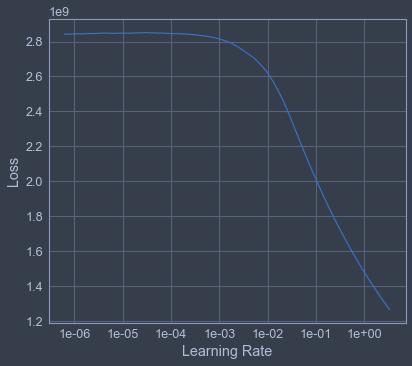

In [310]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(3, 0.000005)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.104228,0.253043,0.485968,00:59
1,0.101620,0.252780,0.485635,00:57
2,0.103672,0.253471,0.486308,00:57


In [191]:
#learn.save('p1.1'); # Good pars for num. of cases
learn.load('p1.1');

In [192]:
#train_data.to_csv('procData.csv', index=False)

In [ ]:
learn.recorder.plot_losses(skip_start=0)

In [194]:
inter = Interpretation.from_learner(learn)
#data['new_cases'].max()

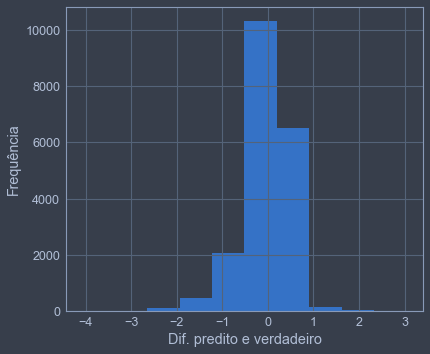

In [195]:
plt.hist((inter.preds.squeeze()) - (inter.y_true))
plt.xlabel('Dif. predito e verdadeiro')
plt.ylabel('Frequência')
plt.show()

In [196]:
(exp(inter.preds.squeeze()) - exp(inter.y_true)).pow(2).mean().sqrt(), exp(((inter.preds.squeeze()) - (inter.y_true)).pow(2).mean().sqrt())
#((inter.preds.squeeze()) - (inter.y_true)).pow(2).mean().sqrt(), (((inter.preds.squeeze()) - (inter.y_true)).pow(2).mean().sqrt())

(tensor(172.5384), tensor(1.6543))

In [197]:
#(inter.y_true - inter.preds).pow(2).mean(0).sqrt()
exp(inter.preds).sum(0), exp(inter.y_true).sum(0)

(tensor([914301.7500]), tensor(965771.0625))

In [198]:
#inter.y_true[inter.top_losses(10).indices], inter.preds[inter.top_losses(10).indices]
inter.top_losses(10)

torch.return_types.topk(
values=tensor([16.6209, 10.7628, 10.6171, 10.5021,  9.2950,  8.9877,  8.6790,  8.6786,
         8.6431,  8.5440]),
indices=tensor([ 6563, 12454, 14528, 18678, 18413, 19384, 15445, 14995, 15052, 19434]))

In [199]:
y_hat1 = learn.get_preds(ds_type='train')
y_hat2 = learn.get_preds()

train_data['preds'] = torch.cat((y_hat1[0].squeeze(), y_hat2[0].squeeze()))
train_data['pred_exp'] = exp(train_data['preds'])

In [215]:
def plot_mun(train_data, mun, var):
    x = train_data[train_data['MUNICIPIO'].eq(mun)].DATA.dt.date
    y = log(train_data[train_data['MUNICIPIO'].eq(mun)][var])
    y_hat = (train_data[train_data['MUNICIPIO'].eq(mun)].preds)
    #x, y, y_hat, len(x), cut_idx
    plt.axvline(x=train_data.DATA.dt.date[cut_idx], linestyle='dashed', color='skyblue')
    plt.plot(x, y, label='Real')
    plt.plot(x, y_hat, label='Predicted')
    plt.legend()
    plt.title(mun)
    plt.xlabel('Data')
    plt.ylabel(var)
    plt.show()

#(ggplot(train_data[train_data.MUNICIPIO.eq('Porto Alegre')][['INT', 'DATA']], aes('DATA', 'INT')) 
# + geom_line() + theme_dark() +xlab('Data') + ylab('Internações') + ggtitle('Porto Alegre'))

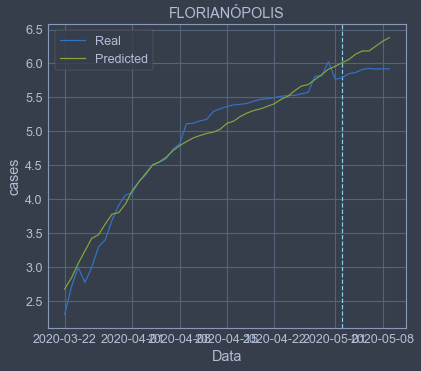

In [216]:
plot_mun(train_data, 'FLORIANÓPOLIS', var='cases')

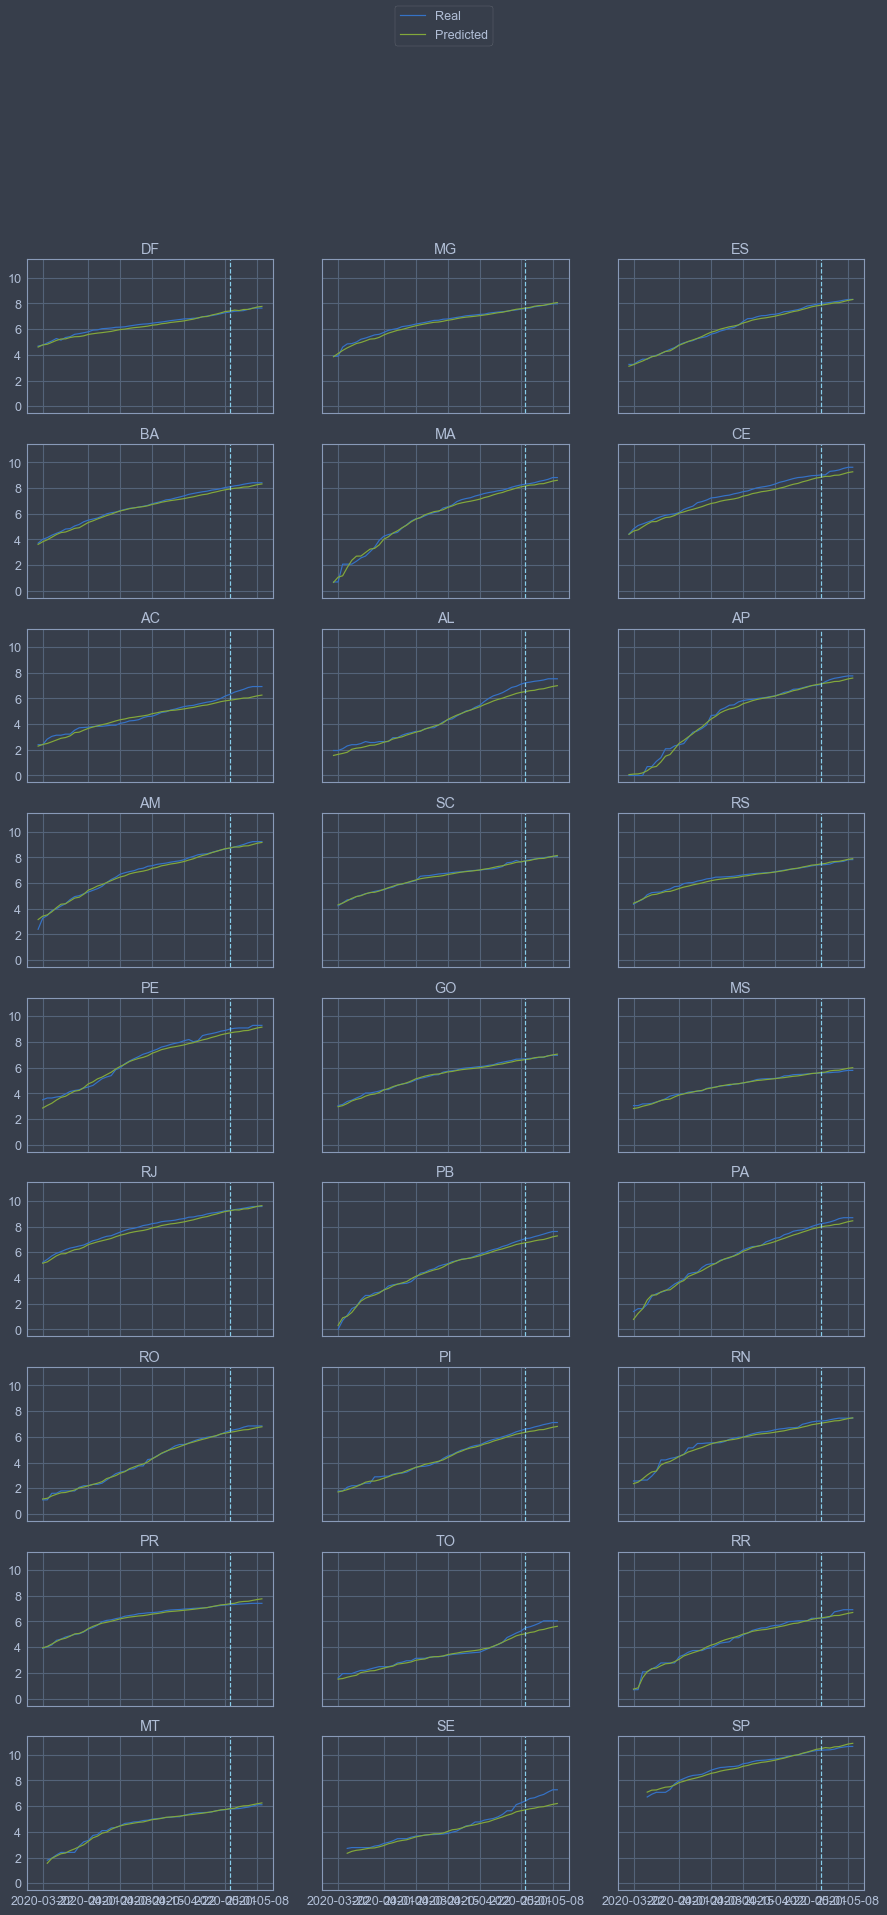

In [202]:
state_dic = {11:'RO', 12:'AC', 13:'AM', 14:'RR', 15:'PA', 16:'AP',
            17:'TO', 21:'MA', 22:'PI', 23:'CE', 24:'RN', 25:'PB',
            26:'PE', 27:'AL', 28:'SE', 29:'BA', 31:'MG', 32:'ES',
            33:'RJ', 35:'SP', 41:'PR', 42:'SC', 43:'RS', 50:'MS',
            51:'MT', 52:'GO', 53:'DF'}
fig, axs = plt.subplots(9, 3, sharex=True, sharey=True, figsize=(15, 30))
stateAll = torch.tensor(train_data['UF'].unique()).reshape(9, 3)
for idx1 in range(9):
    for idx2 in range(3):
        state = int(stateAll[idx1, idx2])
        x = train_data[train_data['UF'].eq(state)].DATA.unique()
        y = log(train_data[train_data['UF'].eq(state)].groupby('DATA').cases.sum())
        y_hat = log(train_data[train_data['UF'].eq(state)].groupby('DATA').pred_exp.sum())
        #x, y, y_hat, len(x), cut_idx
        #axs[idx1, idx2].vlines(x=train_data.DATA.dt.date[cut_idx], ymin=0, ymax=10, linestyles='dashed', colors='skyblue')
        axs[idx1, idx2].plot(x, y, x, y_hat)
        axs[idx1, idx2].axvline(x=train_data.DATA.dt.date[cut_idx], linestyle='dashed', color='skyblue')
        axs[idx1, idx2].set_title(state_dic[state])
        #axs[idx1, idx2].title(state)
        #axs[idx1, idx2].xlabel('Data')
        #axs[idx1, idx2].ylabel('Casos')
plt.figlegend(['Real', 'Predicted'], loc='upper center')
plt.show()


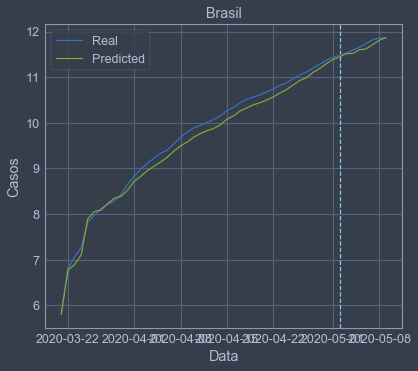

In [214]:
x = train_data.DATA.unique()
y = log(train_data.groupby('DATA').cases.sum())
y_hat = log(train_data.groupby('DATA').pred_exp.sum())
#x, y, y_hat
plt.axvline(x=train_data.DATA.dt.date[cut_idx], linestyle='dashed', color='skyblue')
plt.plot(x, y, label='Real')
plt.plot(x, y_hat, label='Predicted')
plt.title('Brasil')
plt.xlabel('Data')
plt.ylabel('Casos')
plt.legend()
#plt.legend(['Validation set', 'Real', 'Predicted'])
plt.show()
#(ggplot(train_data[train_data.MUNICIPIO.eq('Porto Alegre')][['INT', 'DATA']], aes('DATA', 'INT')) 
# + geom_line() + theme_dark() +xlab('Data') + ylab('Internações') + ggtitle('Porto Alegre'))

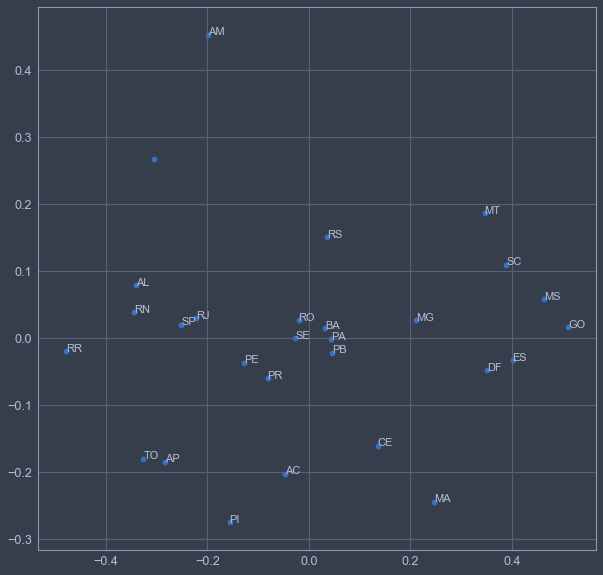

In [204]:
embs = learn.model.embeds[1].weight.data.cpu()
uf_pca = embs.pca(3)
fac0,fac1,fac2 = uf_pca.t()

X = fac0
Y = fac1
plt.figure(figsize=(10,10))
plt.scatter(X, Y)
for i, x, y in zip(state_dic.values(), X, Y):
    plt.text(x,y,i, fontsize=11)
plt.show()

In [205]:
def feature_importance(learner, cat_names, cont_names): 
    # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
        for i, c in enumerate(t):
            print(c)
            loss=[]
            for x,y in iter(learner.data.valid_dl):
                col=x[j][:,i]    #x[0] da hier cat-vars
                idx = torch.randperm(col.nelement())
                x[j][:,i] = col.view(-1)[idx].view(col.size())
                y=y.to('cpu')
                loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
            fi[c]=np.array(loss).mean()-loss0
            print(fi[c])
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})

In [44]:
f1 = feature_importance(learn, cat_vars, cont_vars)

CODUFMUN
1.7101119
UF
0.05612436
FERIADO
0.0
DATAMonth
0.0
DATAWeek
6.514788e-05
DATADay
-2.5421381e-05
DATADayofweek
1.4811754e-05
DATAIs_month_end
0.0
DATAIs_month_start
0.0
DATAIs_quarter_end
0.0
DATAIs_quarter_start
0.0
ESPVIDA
-4.6491623e-06
FECTOT
-0.00063458085
MORT1
-8.076429e-06
MORT5
-3.4570694e-06
RAZDEP
0.0
SOBRE40
0.00028133392
SOBRE60
4.184246e-05
T_ENV
0.00051647425
E_ANOSESTUDO
9.298325e-06
T_ANALF11A14
4.7683716e-07
T_ANALF15A17
-2.4735928e-06
T_ANALF15M
-0.000490278
T_ANALF18A24
1.3113022e-06
T_ANALF18M
-0.00017625093
T_ANALF25A29
-0.00062805414
T_ANALF25M
-0.00030514598
T_ATRASO_0_BASICO
1.424551e-05
T_ATRASO_0_FUND
1.3887882e-05
T_ATRASO_0_MED
-7.1823597e-06
T_ATRASO_1_BASICO
6.750226e-05
T_ATRASO_1_FUND
6.428361e-05
T_ATRASO_1_MED
0.0002091527
T_ATRASO_2_BASICO
2.6017427e-05
T_ATRASO_2_FUND
1.1205673e-05
T_ATRASO_2_MED
2.220273e-05
T_FBBAS
-2.9206276e-05
T_FBFUND
-2.0951033e-05
T_FBMED
0.0026288927
T_FBPRE
-8.183718e-05
T_FBSUPER
-6.0021877e-05
T_FLBAS
-1.7881393e-

In [45]:
f1

,cols,imp
0,CODUFMUN,0.996990
1,DIASCORRMUN,0.776522
2,UF,0.054606
3,T_DENS,0.014163
4,T_FREQ25A29,0.007238
...,...,...
188,T_ANALF15M,-0.000490
189,T_ANALF25A29,-0.000628
190,RDPC5,-0.000630
191,FECTOT,-0.000635


# Modelo de Rede Neural para mortes

In [217]:
train_data = data.copy()
#Exclude observations with zero observed deaths
train_data = train_data.drop(x for x in train_data.index if data.loc[x, 'deaths'] == 0)
train_data.reset_index(inplace=True)
train_data['DIASCORRMUN'] = train_data.groupby('MUNICIPIO').DIASCORR.transform(lambda x: x- min(x))
cut_idx = train_data.DATA[train_data.DATA.eq(max(train_data.DATA) - timedelta(days=7))].index.min()
cut_idx, train_data['DATA'][cut_idx], train_data.shape, log(train_data.deaths.max())

(10718, Timestamp('2020-05-02 00:00:00'), (17338, 204), 7.6544432264701125)

In [218]:
cat_vars = ['CODUFMUN', 'UF', 'FERIADO', 'DATAMonth', 'DATAWeek', 'DATADay',
           'DATADayofweek', 'DATAIs_month_end', 'DATAIs_month_start',
           'DATAIs_quarter_end', 'DATAIs_quarter_start']
target = 'deaths'
cont_vars = [x for x in train_data.columns if x not in cat_vars + [target] + ['DATA', 'index', 'DATAYear', 'MUNICIPIO', 'DATAIs_year_end',
           'DATAIs_year_start', 'DATAElapsed', 'new_deaths', 'new_cases', 'cases', 'level_0']]
transf = [FillMissing, Categorify, Normalize]
#cont_vars

In [219]:
model_data = (TabularList.from_df(train_data, cat_names=cat_vars, cont_names=cont_vars, procs=transf)
             .split_by_idx(range(cut_idx, train_data.shape[0]))
             #.split_by_rand_pct(0.2)
             .label_from_df(cols=target, label_cls=FloatList, log=True)
             #.label_from_func(func=lambda x: x.INT if x.INT.ne(0.0) else x.INT+0.1)
             .databunch(bs=512))

In [220]:
learn = tabular_learner(data=model_data, layers=[200, 50], ps=[0.5, 0.1], emb_drop=0.05, wd=0.2, y_range=(0, 12), metrics=rmse)
                        #loss_func=FlattenedLoss(nn.L1Loss, is_2d=False))

In [221]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [63]                 44,793     True      
______________________________________________________________________
Embedding            [10]                 280        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [5]                  40         True      
_________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


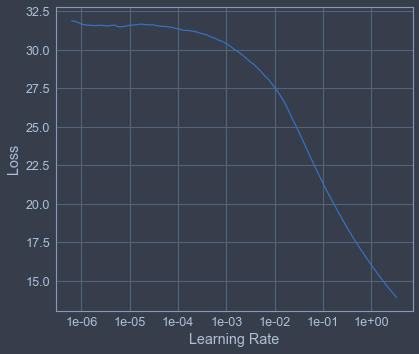

In [68]:
learn.lr_find()
learn.recorder.plot()

In [129]:
learn.fit_one_cycle(20, 0.1)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,15.692172,4.169357,2.041198,00:55
1,8.207890,2.509733,1.579340,00:51
2,5.001419,1.141556,1.065587,00:46
3,3.193863,0.560081,0.744474,00:51
4,2.110260,0.438898,0.659788,00:52
5,1.446457,0.333682,0.575339,00:51
6,1.014115,0.316290,0.560478,00:50
7,0.767196,0.349528,0.588777,00:51
8,0.572303,0.274727,0.521582,00:55
9,0.437093,0.265775,0.513277,01:01


In [222]:
#learn.save('d1.1'); # Good pars for num. of deaths
learn.load('d1.1');

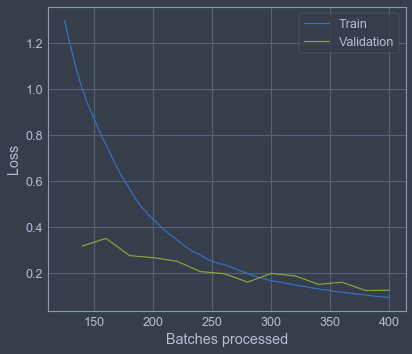

In [131]:
learn.recorder.plot_losses(skip_start=125)

In [223]:
inter = Interpretation.from_learner(learn)
#data['new_cases'].max()

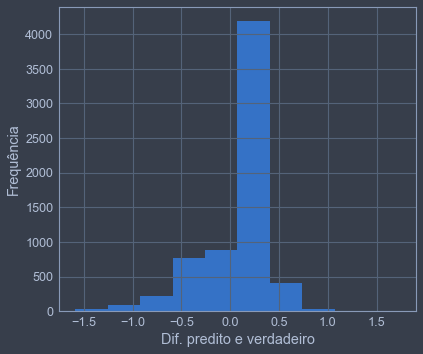

In [224]:
plt.hist((inter.preds.squeeze()) - (inter.y_true))
plt.xlabel('Dif. predito e verdadeiro')
plt.ylabel('Frequência')
plt.show()

In [225]:
(exp(inter.preds.squeeze()) - exp(inter.y_true)).pow(2).mean().sqrt(), exp(((inter.preds.squeeze()) - (inter.y_true)).pow(2).mean().sqrt())
#((inter.preds.squeeze()) - (inter.y_true)).pow(2).mean().sqrt(), (((inter.preds.squeeze()) - (inter.y_true)).pow(2).mean().sqrt())

(tensor(47.2996), tensor(1.4227))

In [226]:
#(inter.y_true - inter.preds).pow(2).mean(0).sqrt()
exp(inter.preds).sum(0), exp(inter.y_true).sum(0)

(tensor([69433.4766]), tensor(66036.))

In [227]:
#inter.y_true[inter.top_losses(10).indices], inter.preds[inter.top_losses(10).indices]
inter.top_losses(20)

torch.return_types.topk(
values=tensor([3.0206, 2.8446, 2.5246, 2.4206, 2.4164, 2.3252, 2.2816, 2.2424, 2.1617,
        2.1560, 2.1472, 2.1421, 2.0942, 2.0615, 1.8917, 1.8839, 1.8831, 1.8817,
        1.8293, 1.7944]),
indices=tensor([6014, 5506, 3896, 4066, 4565, 4558, 3922, 5061, 4484, 3718, 6417, 5357,
        6022, 5886, 3366, 5852, 5543, 3092, 6337, 1596]))

In [228]:
(inter.y_true[inter.top_losses(10).indices],  inter.preds.squeeze()[inter.top_losses(10).indices])
#train_data.loc[4601,['MUNICIPIO', 'DIASCORRMUN', 'DATA', 'cases', 'deaths']]

(tensor([0.0000, 0.0000, 1.9459, 0.0000, 1.9459, 2.4849, 2.3026, 1.9459, 1.6094,
         1.6094]),
 tensor([1.7380, 1.6866, 0.3570, 1.5558, 0.3914, 0.9600, 0.7921, 0.4485, 0.1392,
         0.1411]))

In [229]:
y_hat1 = learn.get_preds(ds_type='train')
y_hat2 = learn.get_preds()

train_data['preds'] = torch.cat((y_hat1[0].squeeze(), y_hat2[0].squeeze()))
train_data['pred_exp'] = exp(train_data['preds'])

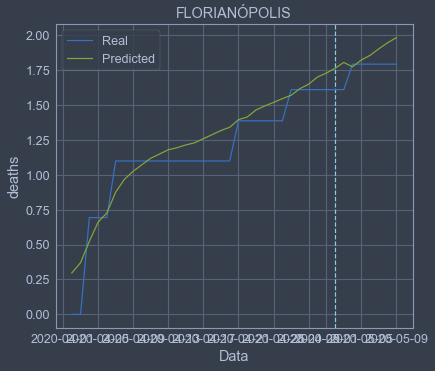

In [230]:
plot_mun(train_data, 'FLORIANÓPOLIS', var='deaths')

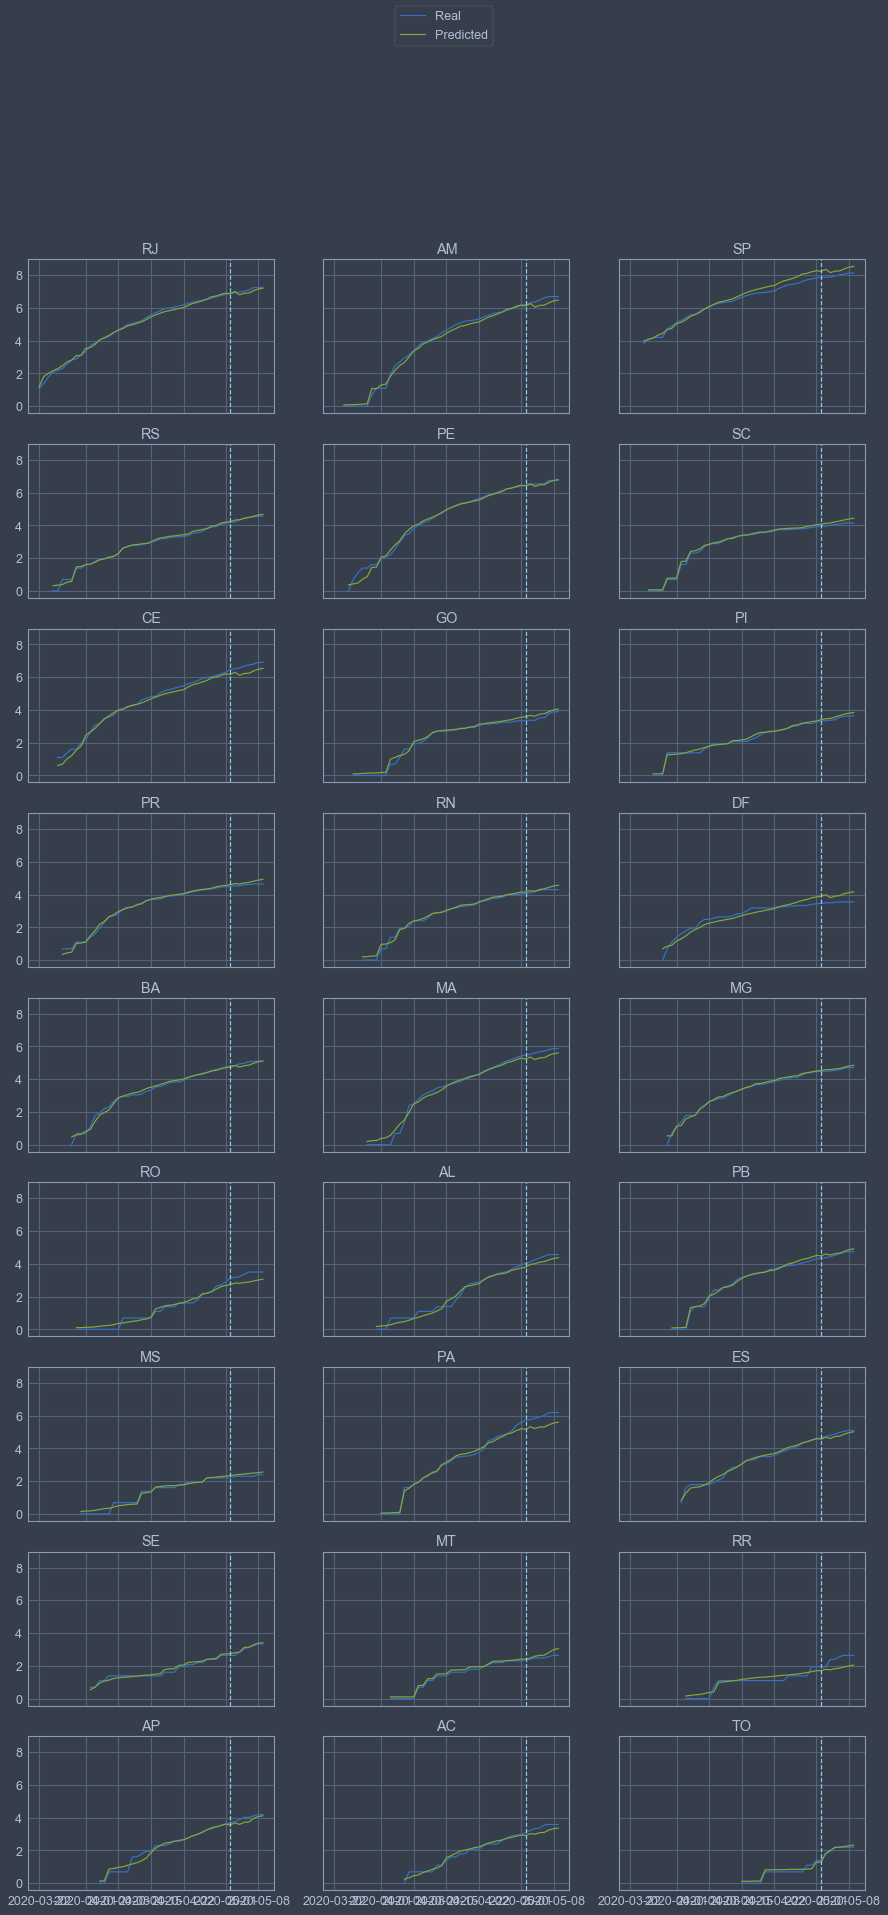

In [231]:
state_dic = {11:'RO', 12:'AC', 13:'AM', 14:'RR', 15:'PA', 16:'AP',
            17:'TO', 21:'MA', 22:'PI', 23:'CE', 24:'RN', 25:'PB',
            26:'PE', 27:'AL', 28:'SE', 29:'BA', 31:'MG', 32:'ES',
            33:'RJ', 35:'SP', 41:'PR', 42:'SC', 43:'RS', 50:'MS',
            51:'MT', 52:'GO', 53:'DF'}
fig, axs = plt.subplots(9, 3, sharex=True, sharey=True, figsize=(15, 30))
stateAll = torch.tensor(train_data['UF'].unique()).reshape(9, 3)
for idx1 in range(9):
    for idx2 in range(3):
        state = int(stateAll[idx1, idx2])
        x = train_data[train_data['UF'].eq(state)].DATA.unique()
        y = log(train_data[train_data['UF'].eq(state)].groupby('DATA').deaths.sum())
        y_hat = log(train_data[train_data['UF'].eq(state)].groupby('DATA').pred_exp.sum())
        #x, y, y_hat, len(x), cut_idx
        #axs[idx1, idx2].vlines(x=train_data.DATA.dt.date[cut_idx], ymin=0, ymax=10, linestyles='dashed', colors='skyblue')
        axs[idx1, idx2].plot(x, y, x, y_hat)
        axs[idx1, idx2].axvline(x=train_data.DATA.dt.date[cut_idx], linestyle='dashed', color='skyblue')
        axs[idx1, idx2].set_title(state_dic[state])
        #axs[idx1, idx2].title(state)
        #axs[idx1, idx2].xlabel('Data')
        #axs[idx1, idx2].ylabel('Casos')
plt.figlegend(['Real', 'Predicted'], loc='upper center')
plt.show()


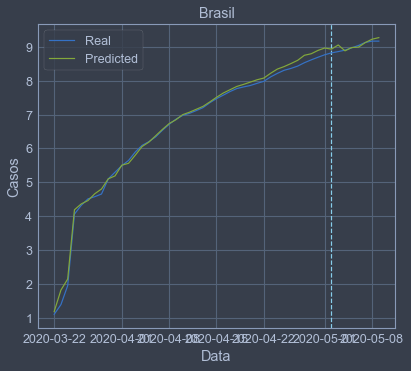

In [233]:
x = train_data.DATA.unique()
y = log(train_data.groupby('DATA').deaths.sum())
y_hat = log(train_data.groupby('DATA').pred_exp.sum())
#x, y, y_hat
plt.axvline(x=train_data.DATA.dt.date[cut_idx], linestyle='dashed', color='skyblue')
plt.plot(x, y, label='Real')
plt.plot(x, y_hat, label='Predicted')
plt.title('Brasil')
plt.xlabel('Data')
plt.ylabel('Casos')
plt.legend()
plt.show()
#(ggplot(train_data[train_data.MUNICIPIO.eq('Porto Alegre')][['INT', 'DATA']], aes('DATA', 'INT')) 
# + geom_line() + theme_dark() +xlab('Data') + ylab('Internações') + ggtitle('Porto Alegre'))